In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix

In [2]:
def calc_acc(annoy_indices, knn_indices, k):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res2 = []
    for a in aa:
        acc2 = 0
        for i in range(len(a)):
            acc2 += a[i]
        if not len(a):
            res2.append(0)
        else:
            res2.append(acc2/len(a))
    return np.array(res2).mean()
def calc_nDCG(annoy_indices, knn_indices, k, discount = 3):
    aa = []
    for i in range(len(annoy_indices)):
        b = []
        for j in annoy_indices[i][1:]:
            if j in knn_indices[i][:k]:
                b.append(1)
            else:
                b.append(0)
        aa.append(b)
    res = []
    for a in aa:
        acc = 0
        for i in range(len(a)):
            acc += a[i]/math.log(i+7, 7)
        if not len(a):
            res.append(0)
        else:
            res.append(acc/len(a))
    return np.array(res).mean()


## loading data

In [3]:
chetor_content = pd.read_csv('./pages_chetor.csv')
chetor_content.head(20)

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
0,2177439,2020-08-09 04:51:12.676435+04:30,"{0.52510529756546,-0.51316374540329,-0.3844181...",وردپرس › خطا,chetor.com/,1,f,f,f,f,148948,336,"{-0.90155690908432,-1.60752034187317,0.1689879...",1015133.0,{}
1,973115,2020-08-09 03:50:47.939727+04:30,"{-0.111537165939808,0.314831465482712,-0.60968...",تبلیغات در وب سایت چطور | چطور,chetor.com/%D8%AA%D8%A8%D9%84%DB%8C%D8%BA%D8%A...,1,t,f,f,t,27016495,336,"{-1.89593696594238,0.659652948379517,-0.852037...",NaN,{}
2,975692,2020-08-09 03:50:49.22613+04:30,"{0.628654301166534,-0.548453748226166,-0.25651...",همکاری با ما | چطور,chetor.com/%D9%87%D9%85%DA%A9%D8%A7%D8%B1%DB%8...,1,t,f,f,t,27004594,336,"{-2.04737234115601,2.28955912590027,-2.1406197...",333341.0,{}
3,2144818,2020-08-09 04:49:41.361098+04:30,"{0.350972026586533,-0.0532753616571426,-0.2103...",چرا باید توسعه فردی را جدی بگیرید؟- چطور,chetor.com/100-%DA%86%D8%B1%D8%A7-%D8%A8%D8%A7...,1,t,f,f,f,5274753,336,"{2.27225732803345,0.7027268409729,0.4857064485...",599277.0,{}
4,2157999,2020-08-09 04:50:09.423651+04:30,"{1.79109728336334,-1.05194425582886,-1.3205879...",دلایل سرد بودن دستان چیست؟ | چطور,chetor.com/100026-%D8%B3%D8%B1%D8%AF-%D8%A8%D9...,1,t,f,f,f,2416997,336,"{2.48906230926514,-1.19906878471375,-1.4995402...",1485027.0,{}
5,4465070,2020-10-06 11:10:31.622853+03:30,"{0.683604598045349,-0.237597540020943,0.257590...",افسوس های من | چطور,chetor.com/100041-%D8%A7%D9%81%D8%B3%D9%88%D8%...,1,t,f,t,t,38243000,336,NaN,1012527.0,{}
6,2142257,2020-08-09 04:49:40.250501+04:30,"{0.63472980260849,0.145868331193924,0.12041924...",خانه پدربزرگ | چطور,chetor.com/100044-%D8%AE%D8%A7%D9%86%D9%87-%D9...,1,t,f,f,f,6160851,336,"{1.89609825611115,1.75975489616394,2.689968109...",1012527.0,{}
7,2123739,2020-08-09 04:48:50.486508+04:30,"{0.63071072101593,-0.431413412094116,-0.302038...",درددل های زیادی در دل اطرافیانم مانده | چطور,chetor.com/100049-%D8%AF%D8%B1%D8%AF%D8%AF%D9%...,1,t,f,f,f,11269955,336,"{1.16336917877197,0.0402661710977554,0.3318648...",NaN,{}
8,2161889,2020-08-09 04:50:45.622368+04:30,"{2.3618381023407,-0.220653653144836,-1.4399104...",درمان سردرد و تسکین فوری آن با ۱۴ روش موثر و ی...,chetor.com/100085-%D8%AF%D8%B1%D9%85%D8%A7%D9%...,1,t,f,f,f,2262178,336,"{2.5592200756073,0.69496887922287,-2.160656929...",1013280.0,{}
9,2161493,2020-08-09 04:50:45.464757+04:30,"{1.23862218856812,-0.99531877040863,-0.5665395...",آیا موز چاق کننده است؟ | چطور,chetor.com/100187-%D8%A2%DB%8C%D8%A7-%D9%85%D9...,1,t,f,f,f,2273389,336,"{1.81400036811829,-1.17559599876404,-1.4106029...",1013170.0,{}


In [4]:
print(chetor_content.shape)

(9640, 15)


In [5]:
chetor_content = chetor_content[chetor_content.included == 't']
chetor_content.shape

(8723, 15)

In [6]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load('./chetor.com/view_matrix/item_indexer.indexer')
        self.user_indexer = AppendIndexer.load('./chetor.com/view_matrix/user_indexer.indexer')
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

## colaborative filtering train

In [54]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 2, 
                      item_min_view = 2)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./chetor.com/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./chetor.com/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./chetor.com/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors, alsTime

In [165]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors, alsTime = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 20)

View matrix loaded in 10.830320835113525 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 27.88295078277588 seconds.

ALS model is fitted in 16.99342918395996 seconds.
Saving Data ...


In [88]:
sparce_matrix40, implicit_matrix40, item_vectors40, user_vectors40 = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 40)

View matrix loaded in 13.539803981781006 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 30.6113121509552 seconds.

ALS model is fitted in 73.34670519828796 seconds.
Saving Data ...


In [57]:
implicit_matrix = implicit_matrix.toarray()
sparce_matrix = sparce_matrix.toarray()

In [9]:
sparce_matrix.shape

(2097150, 8190)

In [10]:
implicit_matrix.shape

(233197, 6877)

## KNN Models

In [8]:
def sk_KNN(item_vectors, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    
    return knn_distances_brute, knn_indices_brute

In [9]:
def sk_KNN_c(item_vectors, mapper, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    a = [[mapper[j] for j in i]for i in knn_indices_brute]
    
    return knn_distances_brute, a

In [10]:
def get_annoy_results(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [11]:
def get_annoy_results_c(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(300, 'angular')
    
    for index, vector in pages_vector.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

## Runing KNN

In [15]:
annoy_indices_CF, annoy_distances, duration = get_annoy_results(item_vectors)

annoy time: 4.866130828857422


In [16]:
knn_distances_brute, knn_indices_brute = sk_KNN(item_vectors)

ball_tree time: 1.2950401306152344


In [17]:
print(annoy_indices_CF[5744])
print(knn_indices_brute[4744])

[5744, 3530, 3043, 1057, 2585, 4612, 2445, 4706, 2543, 5025, 4867, 6677, 4266, 5972, 5630, 5465, 1427, 2554, 4556, 2798, 4364, 143, 715, 1745, 3662, 5410, 3644, 4827, 1708, 4899]
[4744 4929 5770 3348 5491 5529 1649 6845 6405 4657 6292 4918 5814 6095
 4518 6482 5171 4470 2948 3697 6279 5973 6209 6046 4735 4630 4966 6643
 6107 5140]


In [18]:
item_indexer1 = \
AppendIndexer.load('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')

In [19]:
chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(5040))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(3357))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(1364))]
# chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(800))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
316,2152391,2020-08-09 04:50:04.903543+04:30,"{0.898633360862732,-1.01001501083374,0.1571389...",چگونه برای خودمان اهداف شغلی بلندپروازانه اما ...,chetor.com/109447-%D8%A7%D9%87%D8%AF%D8%A7%D9%...,1,t,f,f,f,3069494,336,"{1.16806745529175,-1.26968240737915,1.52262485...",335263.0,{}


## train content based

In [20]:
items = []
nulls = []
for i in item_indexer1.get_items():
    temp = {}
    try:
        item_index = item_indexer1.get(i)
        c_vec = np.array(chetor_content[chetor_content['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        items.append(temp)
    except:
        nulls.append(item_index)

In [21]:
item_content_map = {}
for i in items:
    item_content_map[i['index']] = i['content_vec']
content_vec = []
items_itex = []
for i, j in item_content_map.items():
    content_vec.append(j)
    items_itex.append(i)
# items_itex.index(1600)

In [22]:
annoy_indices_CB, annoy_distances_CB, duration_CB = get_annoy_results_c(item_content_map)

annoy time: 3.800501823425293


In [23]:
knn_distances_brute_CB, knn_indices_brute_CB = sk_KNN_c(content_vec, items_itex)

ball_tree time: 22.649344205856323


In [24]:
print(annoy_indices_CB[6300])
print(knn_indices_brute_CB[6300])

[6758, 3219, 3027, 2311, 4787, 4424, 1790, 1977, 6037, 5307, 5496, 3386, 2232, 1234, 6199, 3688, 2008, 5286, 1027, 3956, 4937, 2930, 6081, 3259, 6115, 4099, 618, 40, 5497, 5894]
[6758, 3027, 1790, 1977, 4424, 6037, 2311, 6081, 1027, 3956, 6199, 1390, 4787, 40, 5286, 4491, 5307, 1234, 2647, 5496, 3219, 5113, 3123, 5790, 1437, 5370, 4720, 2523, 4345, 5020]


In [25]:
chetor_content[chetor_content['id'] == int(item_indexer1.reverse_get(3219))]

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
1509,2166587,2020-08-09 04:50:47.549358+04:30,"{0.7368044257164,-0.137173935770988,-0.4928664...",چیدمان اتاق خواب کوچک؛ ۴ ترفند برای استفاده بی...,chetor.com/137239-%DA%86%DB%8C%D8%AF%D9%85%D8%...,1,t,f,f,f,2078699,336,"{1.59916460514069,-0.668015778064728,-1.301799...",734441.0,{}


## Annoy accuracy

In [91]:
Tknn_distances_brute, Tknn_indices_brute = sk_KNN(item_vectors40, number_of_neighbours = 10)

ball_tree time: 2.261575937271118


In [93]:
for i in [5, 10, 30, 50, 70, 100, 150, 200, 300]:
    Tannoy_indices_CF, Tannoy_distances, Tduration = get_annoy_results(item_vectors40, number_of_trees = i, number_of_neighbours = 10)
    print(calc_acc(Tannoy_indices_CF, Tknn_indices_brute, 10))

annoy time: 0.22839117050170898
0.249866705443265
annoy time: 0.26001524925231934
0.27605706622719856
annoy time: 0.5019259452819824
0.28937036498473173
annoy time: 0.7594432830810547
0.2905175060184512
annoy time: 1.0394959449768066
0.2908244874218409
annoy time: 1.5981428623199463
0.2913899794807167
annoy time: 2.3756332397460938
0.29109915499329486
annoy time: 3.187662124633789
0.2910506842453912
annoy time: 4.446425676345825
0.2912445672370058


In [96]:
Aknn_distances_brute_CB, Aknn_indices_brute_CB = sk_KNN_c(content_vec, items_itex, number_of_neighbours = 10)

ball_tree time: 24.4027316570282


In [97]:
for i in [5, 10, 30, 50, 70, 100, 150, 200, 300]:
    Tannoy_indices_CB, Tannoy_distances_CB, Tduration_CB = get_annoy_results_c(item_content_map, number_of_trees = i, number_of_neighbours = 30)
    print(calc_acc(Tannoy_indices_CB, Aknn_indices_brute_CB, 10))

annoy time: 0.9081950187683105
0.19831641093846303
annoy time: 1.0917932987213135
0.2382705636833512
annoy time: 1.487757921218872
0.2670170088991252
annoy time: 1.8884131908416748
0.2738724711021723
annoy time: 2.426100015640259
0.2766027616483385
annoy time: 2.7697558403015137
0.27857073344795147
annoy time: 3.644639015197754
0.28005211881359415
annoy time: 4.566069841384888
0.2806143964706264
annoy time: 6.177072048187256
0.28119289367545763


## time - #features

In [12]:
alst = []
annoyt = []
knnt = []
accs = []
ndcgs = []
features = [5, 10, 20, 30, 40, 60, 80, 100, 120]
# matrix = ViewMatrix.load_matrix('./chetor.com/view_matrix/lil_matrix.npz')
# print('hi')
# sparce_matrix = matrix.to_csr()
# matrix.make_dense(user_min_view = 2, 
#                   item_min_view = 2)
# implicit_matrix = matrix.to_csr()
# print('hi')

In [ ]:
for i in features:
    als_model = ALS.Als(num_factors = i,
                    iterations = 15,
                    num_threads = 15,
                    alpha = 15)
    now = time.time()
    als_model.fit(implicit_matrix)
    alst.append(time.time() - now)
    print(alst[-1])
    
    now = time.time()
    annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(als_model.item_vectors, number_of_neighbours = 10)
    annoyt.append(time.time() - now)
    
    now = time.time()
    knn_distances_brutei, knn_indices_brutei = sk_KNN(als_model.item_vectors, number_of_neighbours = 10)
    knnt.append(time.time() - now)
    
    accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
    ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))
    
    print(accs[-1], ndcgs[-1])
    

8.252465963363647
annoy time: 3.4397029876708984
ball_tree time: 0.6495327949523926
0.1982938296737919 0.16792937473392983
15.804805040359497
annoy time: 3.0062458515167236
ball_tree time: 1.240562915802002
0.24648991000597809 0.2082443364245255
67.85255289077759


In [14]:
sparce_matrix5, implicit_matrix5, item_vectors5, user_vectors5, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 5)
alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors5, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors5, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 8.421388149261475 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 23.98810577392578 seconds.

ALS model is fitted in 4.169722080230713 seconds.
Saving Data ...
annoy time: 3.5787949562072754
ball_tree time: 0.38141775131225586


In [16]:
sparce_matrix10, implicit_matrix10, item_vectors10, user_vectors10, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 10)
alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors10, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors10, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 9.26488709449768 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 25.223467111587524 seconds.

ALS model is fitted in 8.152777910232544 seconds.
Saving Data ...
annoy time: 3.364394187927246
ball_tree time: 0.6392197608947754


In [17]:
sparce_matrix20, implicit_matrix20, item_vectors20, user_vectors20, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 20)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors20, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors20, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 9.533482074737549 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 25.60280704498291 seconds.

ALS model is fitted in 16.56444811820984 seconds.
Saving Data ...
annoy time: 3.0830540657043457
ball_tree time: 1.2460169792175293


In [19]:
sparce_matrix30, implicit_matrix30, item_vectors30, user_vectors30, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 30)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors30, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors30, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 9.404157876968384 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 26.19858479499817 seconds.

ALS model is fitted in 30.480173110961914 seconds.
Saving Data ...
annoy time: 3.15132212638855
ball_tree time: 1.8060648441314697


In [20]:
sparce_matrix40, implicit_matrix40, item_vectors40, user_vectors40, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 40)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors40, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors40, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 9.882529020309448 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 26.362075090408325 seconds.

ALS model is fitted in 70.78626012802124 seconds.
Saving Data ...
annoy time: 2.4998319149017334
ball_tree time: 2.561044931411743


In [24]:
sparce_matrix60, implicit_matrix60, item_vectors60, user_vectors60, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 60)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors60, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors60, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 11.256525993347168 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 28.380483865737915 seconds.

ALS model is fitted in 109.9928469657898 seconds.
Saving Data ...
annoy time: 2.595827102661133
ball_tree time: 3.4620161056518555


In [25]:
sparce_matrix80, implicit_matrix80, item_vectors80, user_vectors80, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 80)


alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors80, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors80, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 11.301024198532104 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 30.144675970077515 seconds.

ALS model is fitted in 195.58615899085999 seconds.
Saving Data ...
annoy time: 1.906224012374878
ball_tree time: 4.040751934051514


In [28]:
sparce_matrix100, implicit_matrix100, item_vectors100, user_vectors100, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 100)


alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors100, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors100, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 14.386934041976929 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 33.11537313461304 seconds.

ALS model is fitted in 286.2236897945404 seconds.
Saving Data ...
annoy time: 2.24938702583313
ball_tree time: 5.893309116363525


In [37]:
sparce_matrix120, implicit_matrix120, item_vectors120, user_vectors120, ALS_Time = \
CFTrain('./chetor.com/view_matrix/lil_matrix.npz', factors = 120)

alst.append(ALS_Time)

now = time.time()
annoy_indices_CFi, annoy_distancesi, durationi = get_annoy_results(item_vectors120, number_of_neighbours = 10)
annoyt.append(time.time() - now)

now = time.time()
knn_distances_brutei, knn_indices_brutei = sk_KNN(item_vectors120, number_of_neighbours = 10)
knnt.append(time.time() - now)

accs.append(calc_acc(annoy_indices_CFi, knn_indices_brutei, 10))
ndcgs.append(calc_nDCG(annoy_indices_CFi, knn_indices_brutei, 10))

View matrix loaded in 13.203545808792114 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 27.783863067626953 seconds.

ALS model is fitted in 389.85923314094543 seconds.
Saving Data ...
annoy time: 2.0993940830230713
ball_tree time: 7.551283836364746


In [38]:
print(alst)
print(annoyt)
print(knnt)
print(accs)
print(ndcgs)

[4.1697211265563965, 8.152775049209595, 16.564445972442627, 30.48016929626465, 70.78625702857971, 109.99284291267395, 195.58615708351135, 286.22368693351746, 389.8592312335968]
[3.5804030895233154, 3.3697850704193115, 3.0885722637176514, 3.158419132232666, 2.507100820541382, 2.6008200645446777, 1.9109199047088623, 2.2570509910583496, 2.107421875]
[0.38172173500061035, 0.6395487785339355, 1.2463529109954834, 1.8065781593322754, 2.561837911605835, 3.4627492427825928, 4.041607141494751, 5.893915891647339, 7.5519700050354]
[0.13206663112145153, 0.19412534535407883, 0.24949509637600376, 0.27030520414263326, 0.29252096359846835, 0.3109721616337874, 0.3327355274425218, 0.34367375955277657, 0.35792415943644673]
[0.11109424199359078, 0.16411032617861207, 0.21075285052119708, 0.22848147671327795, 0.2467794100027441, 0.2623771801381345, 0.28050345199151944, 0.2898135629491892, 0.3018103177712269]


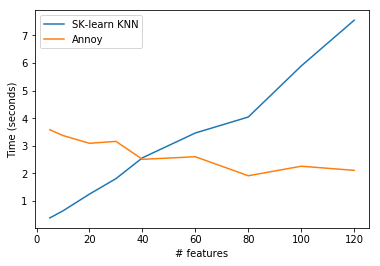

In [40]:
features = [5, 10, 20, 30, 40, 60, 80, 100, 120]
plt.plot(features, knnt, label = 'SK-learn KNN')
plt.plot(features, annoyt, label = 'Annoy')
plt.xlabel('# features')
plt.ylabel('Time (seconds)')
plt.legend(loc="upper left")

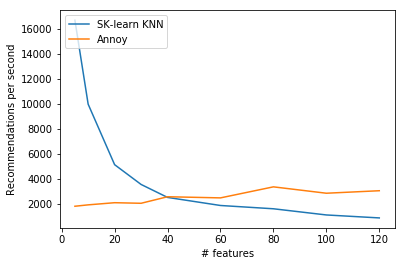

In [41]:
features = [5, 10, 20, 30, 40, 60, 80, 100, 120]
plt.plot(features, 6378/np.array(knnt), label = 'SK-learn KNN')
plt.plot(features, 6378/np.array(annoyt), label = 'Annoy')
plt.xlabel('# features')
plt.ylabel('Recommendations per second')
plt.legend(loc="upper left")

## acc-time-#features

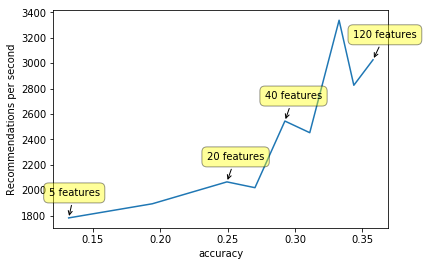

In [51]:
att = 6378/np.array(annoyt)
plt.plot(accs, att)
plt.ylabel("Recommendations per second")
plt.xlabel("accuracy")
for i in [0,2,4,8]:
    plt.annotate(
            str(features[i]) + " features",
            xy=(accs[i], att[i]), xytext=(-20, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

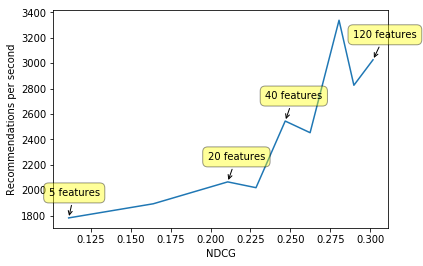

In [179]:
att = 6378/np.array(annoyt)
plt.plot(ndcgs, att)
plt.ylabel("Recommendations per second")
plt.xlabel("NDCG")
for i in [0,2,4,8]:
    plt.annotate(
            str(features[i]) + " features",
            xy=(ndcgs[i], att[i]), xytext=(-20, 30),
            textcoords='offset points', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.4),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

## Precision Recall @k and MAE

In [28]:
now = time.time()
aproximated_matrix = np.matmul(user_vectors, np.transpose(item_vectors))
time.time() - now

19.879060983657837

In [30]:
start = time.time()
# implicit_matrix = implicit_matrix.toarray()
absolute_error = abs(aproximated_matrix - implicit_matrix)
time.time() - start

232.96968388557434

In [31]:
start = time.time()
MAE = absolute_error.mean()
time.time() - start

71.03863096237183

In [32]:
MAE

0.009043916284864414

In [27]:
idk = []
for i in tqdm(range(len(implicit_matrix))):
    temp = []
    for j in range(len(implicit_matrix[i])):
        if implicit_matrix[i][j] > 0:
            temp.append((implicit_matrix[i][j], j))
    idk.append(temp)

100%|██████████| 233197/233197 [18:19<00:00, 212.01it/s]


In [41]:
idk2 = []
for i in tqdm(range(len(aproximated_matrix))):
    temp = []
    for j in range(len(aproximated_matrix[i])):
        if aproximated_matrix[i][j] > 0.3:
            temp.append((aproximated_matrix[i][j], j))
    idk2.append(temp)

100%|██████████| 233197/233197 [15:20<00:00, 253.30it/s]


In [80]:
for i in tqdm(range(len(idk2))):
    idk2[i] = sorted(idk2[i], key=lambda x: x[0], reverse=True)

100%|██████████| 233197/233197 [00:00<00:00, 263142.36it/s]


In [86]:
def Precision_recall_at_k(idk2, idk, k):
    users_visited_indeces = \
    [[i[1] for i in idk[j]] for j in range(len(idk))]
#     print(users_visited_indeces[0:10])
    recommended_relevant = []
    relevants = []
    for i in range(len(idk2)):
        temp = 0
        if len(idk2[i]) >= k and len(users_visited_indeces[i]) >= k:
            for j in range(len(idk2[i][0:k+1])):
                if idk2[i][j][1] in users_visited_indeces[i]:
                    temp += 1
            recommended_relevant.append(temp)
            relevants.append(len(users_visited_indeces[i]))
    p = (np.array(recommended_relevant) / k).mean()
    r = []
    for i in zip(recommended_relevant, relevants):
        r.append(i[0]/i[1])
    r = np.array(r).mean()
    return p, r

In [87]:
for k in range(1, 20):
    print('k =', k, Precision_recall_at_k(idk2, idk, k))

k = 1 (0.7186354499231405, 0.3132991983320419)
k = 2 (0.45802332358454406, 0.39563191122090663)
k = 3 (0.3964406552864489, 0.33340775120759264)
k = 4 (0.3518457896857373, 0.28333117710725014)
k = 5 (0.3264939622252039, 0.2523960932844422)
k = 6 (0.31026053776903356, 0.231139391231143)
k = 7 (0.30018033558099416, 0.2186396367495723)
k = 8 (0.29234575087310827, 0.20980850487899763)
k = 9 (0.2872784150156413, 0.204103039836464)
k = 10 (0.2821524064171123, 0.1993732143623082)
k = 11 (0.27719190208605954, 0.1940893510669637)
k = 12 (0.2746406570841889, 0.19230763612031124)
k = 13 (0.2700897117770567, 0.18766172434375045)
k = 14 (0.2647549530761209, 0.1844010920044037)
k = 15 (0.25830429732868754, 0.17646792331281605)
k = 16 (0.2542162698412698, 0.17401698465680013)
k = 17 (0.24929360390444388, 0.17363907796836417)
k = 18 (0.244718792866941, 0.17004162464521388)
k = 19 (0.24428718855963436, 0.1696894556403601)


## popularity bias wrt alg

In [178]:
def CFTrain2(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 1, 
                      item_min_view = 1)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./chetor.com/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./chetor.com/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./chetor.com/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./chetor.com/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors, alsTime

In [132]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors, alsTime = \
CFTrain2('./chetor.com/view_matrix/lil_matrix.npz', factors = 20, _alpha = 1)

View matrix loaded in 8.806686878204346 seconds.
Number of users which should be deleted: 1863687
Number products which should be deleted: 1308
Number of users which should be deleted: 265
Number products which should be deleted: 4
Number of users which should be deleted: 1
Number products which should be deleted: 1
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 26.60288381576538 seconds.

ALS model is fitted in 17.589404106140137 seconds.
Saving Data ...


In [166]:
implicit_matrix = implicit_matrix.toarray()

In [167]:
popularity_count = {}
for i, j in tqdm(enumerate(implicit_matrix.T)):
    popularity_count[i] = np.greater(j, 0).sum()

6877it [00:57, 118.72it/s]


In [168]:
site_trend = {k: v for k, v in sorted(popularity_count.items(), key=lambda item: item[1], reverse = True)}

In [169]:
len(site_trend)

6877

In [170]:
pop = []
item = []
for i, j in site_trend.items():
    pop.append(j)
    item.append(i)

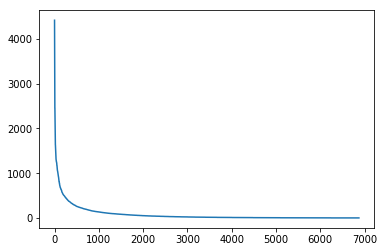

In [171]:
plt.plot(pop[3:])

In [172]:
ind, dis, d = get_annoy_results(item_vectors, number_of_neighbours = 30)
ind2 = []
for i in ind:
    ind2.append(i[1:])

annoy time: 5.80443811416626


In [173]:
ind2 = np.array(list((np.array(ind2)).flatten()))

In [157]:
knn_indices_brutei_st = np.array(list((np.array(knn_indices_brutei_st)).flatten()))

In [174]:
res = []
for i in item:
    res.append(np.equal(ind2, i).sum())

In [159]:
def a(s):
    r = []
    for i in range(len(s)-500):
        r.append(np.array(s[i:i+500]).mean())
    return r

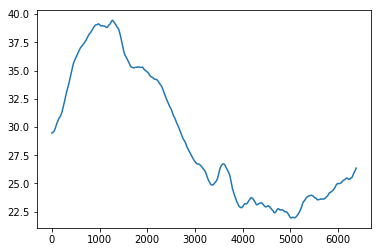

In [177]:
res = a(res)
plt.plot(res)